# tempoSOAP analysis

an example for a tempoSOAP analysis as in the [original paper](https://arxiv.org/abs/2302.09673v2)


In [1]:
import SOAPify.HDF5er as HDF5er
from SOAPify import (
    saponifyTrajectory,
    fillSOAPVectorFromdscribe,
    normalizeArray,
    getSOAPSettings,
)
from SOAPify.analysis import tempoSOAPsimple
import h5py
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Circle
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.signal import savgol_filter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from multiprocessing.pool import ThreadPool as Pool
from seaborn import kdeplot

SOAPrcut = 4.48023312
SOAPnmax = 8
SOAPlmax = 8


## Load data

Let's get the data:
```bash
wget https://github.com/GMPavanLab/dynNP/releases/download/V1.0-trajectories/ico309.hdf5
```
We'll start by caclulating the neighbours and the LENS parameters

using cutoff=4.48023312 that is 10% more than the Au cell

In [2]:
trajFileName = "ico309.hdf5"
trajAddress = "ico309-SV_18631-SL_31922-T_500"


In [3]:
def prepareSOAP(trajFileName, trajAddress):
    soapFileName = trajFileName.split(".")[0] + "soap.hdf5"
    print(trajFileName, soapFileName)
    with h5py.File(trajFileName, "r") as workFile, h5py.File(
        soapFileName, "a"
    ) as soapFile:
        soapFile.require_group("SOAP")
        # skips if the soap trajectory is already present
        if trajAddress not in soapFile["SOAP"]:
            saponifyTrajectory(
                trajContainer=workFile[f"Trajectories/{trajAddress}"],
                SOAPoutContainer=soapFile["SOAP"],
                SOAPOutputChunkDim=1000,
                SOAPnJobs=32,
                SOAPrcut=SOAPrcut,
                SOAPnmax=SOAPnmax,
                SOAPlmax=SOAPlmax,
            )
    return soapFileName


soapFileName = prepareSOAP(trajFileName, trajAddress)


ico309.hdf5 ico309soap.hdf5


Let's get the raw tempSOAP array without clogging up the memory

In [4]:
def getTempoSOAP(soapFileName, trajAddress):
    with h5py.File(soapFileName, "r") as f:
        ds = f[f"/SOAP/{trajAddress}"]
        fillSettings = getSOAPSettings(ds)
        print(fillSettings)
        print(ds.shape)

        timedSOAP = np.zeros((ds.shape[0] - 1, ds.shape[1]))

        print(timedSOAP.shape)
        slide = 0
        # this looks a lot convoluted, but it is way faster than working one atom
        # at a time
        for c in ds.iter_chunks():
            theSlice = slice(c[0].start - slide, c[0].stop, c[0].step)
            outSlice = slice(c[0].start - slide, c[0].stop - 1, c[0].step)
            print(c[0], theSlice, outSlice)
            timedSOAP[outSlice], _ = tempoSOAPsimple(
                normalizeArray(fillSOAPVectorFromdscribe(ds[theSlice], **fillSettings))
            )
            slide = 1

        return timedSOAP, np.diff(timedSOAP.T, axis=-1)


tSOAP, dtSOAP = getTempoSOAP(soapFileName, trajAddress)


{'nMax': 8, 'lMax': 8, 'atomTypes': array(['Au'], dtype=object), 'atomicSlices': {'AuAu': slice(0, 324, None)}}
(20000, 309, 324)
(19999, 309)
slice(0, 1000, 1) slice(0, 1000, 1) slice(0, 999, 1)
slice(1000, 2000, 1) slice(999, 2000, 1) slice(999, 1999, 1)
slice(2000, 3000, 1) slice(1999, 3000, 1) slice(1999, 2999, 1)
slice(3000, 4000, 1) slice(2999, 4000, 1) slice(2999, 3999, 1)
slice(4000, 5000, 1) slice(3999, 5000, 1) slice(3999, 4999, 1)
slice(5000, 6000, 1) slice(4999, 6000, 1) slice(4999, 5999, 1)
slice(6000, 7000, 1) slice(5999, 7000, 1) slice(5999, 6999, 1)
slice(7000, 8000, 1) slice(6999, 8000, 1) slice(6999, 7999, 1)
slice(8000, 9000, 1) slice(7999, 9000, 1) slice(7999, 8999, 1)
slice(9000, 10000, 1) slice(8999, 10000, 1) slice(8999, 9999, 1)
slice(10000, 11000, 1) slice(9999, 11000, 1) slice(9999, 10999, 1)
slice(11000, 12000, 1) slice(10999, 12000, 1) slice(10999, 11999, 1)
slice(12000, 13000, 1) slice(11999, 13000, 1) slice(11999, 12999, 1)
slice(13000, 14000, 1) slice(129

In [5]:
print(tSOAP.shape)
print(dtSOAP.shape)


(19999, 309)
(309, 19998)


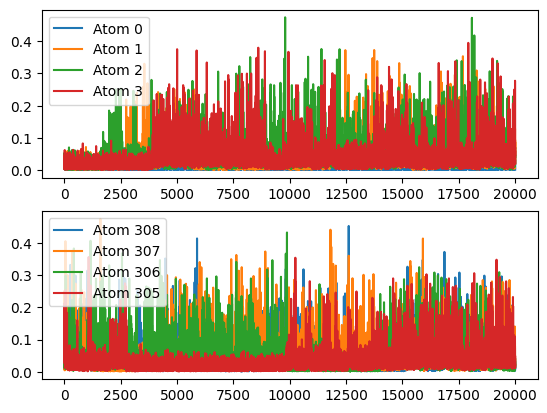

In [6]:
fig, axes = plt.subplots(2, sharey=True)
for i in range(4):
    axes[0].plot(tSOAP[:, i], label=f"Atom {i}")
    axes[1].plot(tSOAP[:, 308 - i], label=f"Atom {308-i}")

for ax in axes:
    ax.legend()


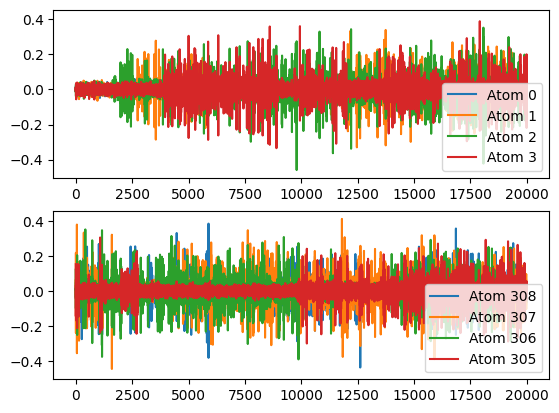

In [7]:
fig, axes = plt.subplots(2, sharey=True)
for i in range(4):
    axes[0].plot(dtSOAP[i], label=f"Atom {i}")
    axes[1].plot(dtSOAP[308 - i], label=f"Atom {308-i}")

for ax in axes:
    ax.legend()


## Filtering

Let's chose an atom  try to apply a filter on it.
We want try to reduce the signal to noise ratio, so we calculate the mean of the s/n for all atoms:

In [8]:
def signaltonoise(a: np.array, axis, ddof):
    """Given an array, retunrs its signal to noise value of its compontens"""
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return 20 * np.log10(abs(np.where(sd == 0, 0, m / sd)))


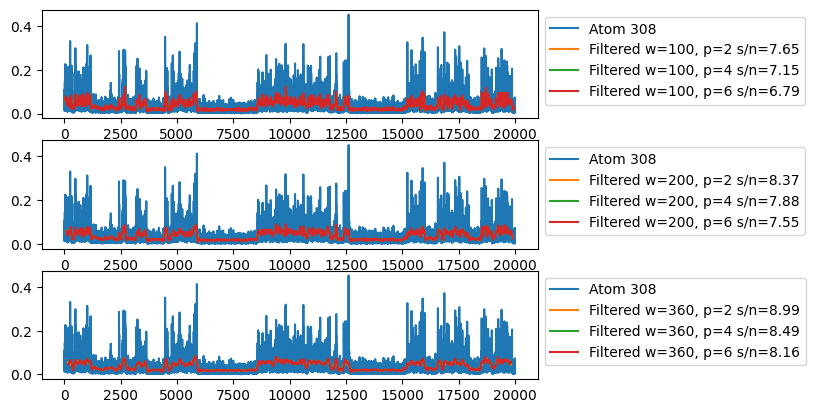

In [9]:
atom = 308
savGolPrint = np.arange(tSOAP.T[atom].shape[0])
windows = [100, 200, 360]
polyorders = [2, 4, 6]
fig, axes = plt.subplots(len(windows), sharey=True)

for ax, window_length in zip(axes, windows):
    windowToPlot = slice(window_length // 2, -window_length // 2)
    ax.plot(tSOAP.T[atom], label=f"Atom {atom}")
    for polyorder in polyorders:
        savgol = savgol_filter(
            tSOAP.T, window_length=window_length, polyorder=polyorder, axis=-1
        )

        sr_ratio = signaltonoise(savgol[:, windowToPlot], axis=-1, ddof=0)

        ax.plot(
            savGolPrint[windowToPlot],
            savgol[atom, windowToPlot],
            label=f"Filtered w={window_length}, p={polyorder} s/n={np.mean(sr_ratio):.2f}",
        )
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1))


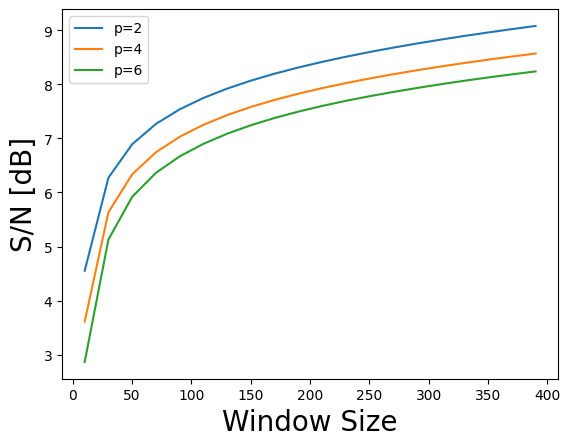

In [10]:
windows = np.arange(10, 400, 20)
polyorders = [2, 4, 6]
fig, ax = plt.subplots(1)


for polyorder in polyorders:
    meansrRatios = np.empty((len(windows), 2))
    for i, window_length in enumerate(windows):
        windowToPlot = slice(window_length // 2, -window_length // 2)
        savgol = savgol_filter(
            tSOAP.T, window_length=window_length, polyorder=polyorder, axis=-1
        )
        sr_ratio = signaltonoise(savgol[:, windowToPlot], axis=-1, ddof=0)
        meansrRatios[i] = [window_length, np.mean(sr_ratio)]
    ax.plot(meansrRatios[:, 0], meansrRatios[:, 1], label=f"p={polyorder}")
ax.set_xlabel("Window Size", fontsize=20)
ax.set_ylabel("S/N [dB]", fontsize=20)

_ = ax.legend()


We proceed with `window_length=360` and `polyorder=2`, it as a 8.99 dB signal to noise ratio, that is quite accettable,
and apply the filter to all of the tSOAP trajectories

In [11]:
window_length = 360
polyorder = 2
windowToUSE = slice(window_length // 2, -window_length // 2)
filteredtSOAP = savgol_filter(
    tSOAP.T, window_length=window_length, polyorder=polyorder, axis=-1
)


In [12]:
bestnclusters = 5
clusters = KMeans(bestnclusters, random_state=12345).fit_predict(
    filteredtSOAP.reshape(-1, 1)
)
data_KM = {}
for i in range(bestnclusters):
    data_KM[i] = {}
    data_KM[i]["elements"] = filteredtSOAP.reshape((-1))[clusters == i]
    data_KM[i]["min"] = np.min(data_KM[i]["elements"])
    data_KM[i]["max"] = np.max(data_KM[i]["elements"])


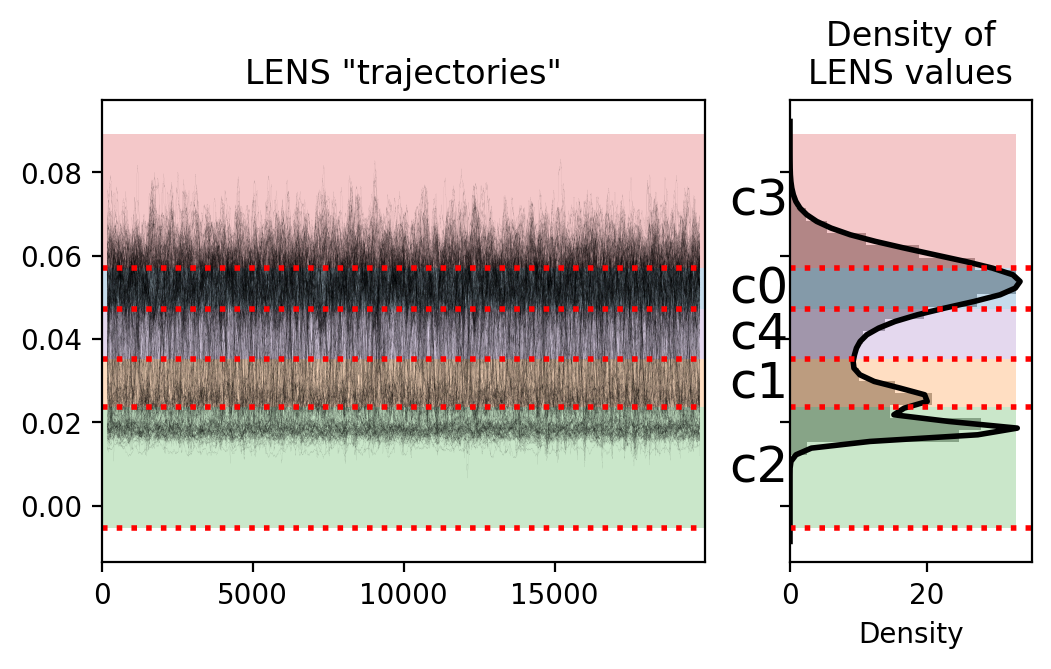

In [13]:
fig, axes = plt.subplots(
    1, 2, figsize=(6, 3), dpi=200, width_ratios=[3, 1.2], sharey=True
)

for flns in filteredtSOAP:
    axes[0].plot(
        savGolPrint[windowToUSE],
        flns[windowToUSE],
        color="k",
        linewidth=0.01,
        # alpha=0.9,
    )
hist = axes[1].hist(
    filteredtSOAP.reshape((-1)),
    alpha=0.7,
    color="gray",
    bins="doane",
    density=True,
    orientation="horizontal",
)
kde = kdeplot(
    y=filteredtSOAP.reshape((-1)),
    bw_adjust=1.5,
    linewidth=2,
    color="black",
    # gridsize=500,
    gridsize=2 * (hist[1].shape[0] - 1),
    ax=axes[1],
)
axes[0].set_title('LENS "trajectories"')
axes[0].set_xlim(0, len(savGolPrint))
axes[1].set_title("Density of\nLENS values")
height = np.max(hist[0])
for cname, data in data_KM.items():
    # center = delta+data['min']
    bin_size = data["max"] - data["min"]
    for i, ax in enumerate(axes):
        ax.barh(
            y=data["min"],
            width=len(savGolPrint) if i == 0 else height,
            height=bin_size,
            align="edge",
            alpha=0.25,
            # color=colors[idx_m],
            linewidth=2,
        )
        ax.axhline(y=data["min"], c="red", linewidth=2, linestyle=":")
        if i == 1:
            ax.text(
                -0.25,
                data["min"] + bin_size / 2.0,
                f"c{cname}",
                va="center",
                ha="right",
                fontsize=18,
            )


The idea is to play with the clustering until you are satisfied, then to visualize and try to give an interpretation (and then change agani the method of clustering until you are satisfied):

## Visualization: ovito-compatible

Let's define some helper functions and then export the data in a xyz that is compatible with ovito

In [14]:
def prepareData(x, /):
    """prepares an array from shape (atom,frames) to  (frames,atom)"""
    shape = x.shape
    toret = np.empty((shape[1], shape[0]), dtype=x.dtype)
    for i, atomvalues in enumerate(x):
        toret[:, i] = atomvalues
    return toret


# classyfing by knoing the min/max of the clusters
def classifying(x, classDict):
    toret = np.ones_like(x, dtype=int) * (len(classDict) - 1)
    # todo: sort  by max and then classify
    minmax = [[cname, data["max"]] for cname, data in data_KM.items()]
    minmax = sorted(minmax, key=lambda x: -x[1])
    # print(minmax)
    for cname, myMax in minmax:
        toret[x < myMax] = int(cname)
    return toret


# classifying(filteredLENS,data_KM)
classifiedFilteredtSOAP = classifying(filteredtSOAP, data_KM)


In [15]:
def export(trajFileName, trajAddress):
    # as a function, so the universe should be garbage collected correctly
    with h5py.File(trajFileName, "r") as trajFile, open(
        "outClassified.xyz", "w"
    ) as xyzFile:
        from MDAnalysis.transformations import fit_rot_trans

        wantedTrajectory = slice(-1)
        tgroup = trajFile[f"/Trajectories/{trajAddress}"]
        universe = HDF5er.createUniverseFromSlice(tgroup, wantedTrajectory)
        ref = HDF5er.createUniverseFromSlice(tgroup, [0])
        universe.trajectory.add_transformations(fit_rot_trans(universe, ref))

        HDF5er.getXYZfromMDA(
            xyzFile,
            universe,
            allFramesProperty='Origin="-40 -40 -40"',
            tSOAP=tSOAP,
            filteredtSOAP=prepareData(filteredtSOAP),
            proposedClassification=prepareData(classifiedFilteredtSOAP),
        )


export(trajFileName, trajAddress)


/home/daniele/repos/mySoapify/env/lib/python3.8/site-packages/MDAnalysis/analysis/align.py:1466: SelectionWarning: Atoms could not be matched since they don't contain masses.
  warnings.warn(msg, category=SelectionWarning)


Let's visualize a few tSOAP trajectories colored by the cluster in time

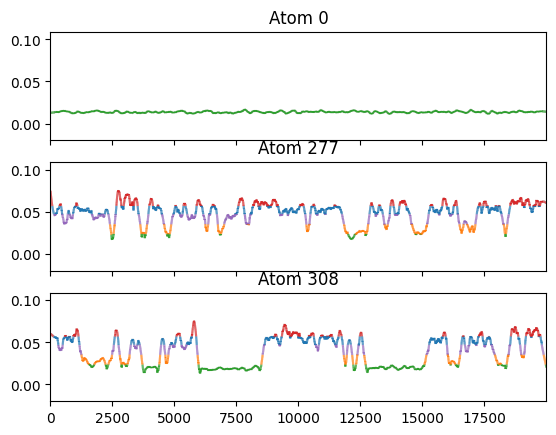

In [16]:
fig, axes = plt.subplots(3, sharey=True, sharex=True)

minmax = [[cname, data["max"]] for cname, data in data_KM.items()]
minmax = sorted(minmax, key=lambda x: x[1])
cmap = ListedColormap([f"C{m[0]}" for m in minmax])
norm = BoundaryNorm([0] + [m[1] for m in minmax], cmap.N)

for atom, ax in zip([0, 277, 308], axes):
    points = np.array([savGolPrint, filteredtSOAP[atom]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(filteredtSOAP[atom])

    line = ax.add_collection(lc)
    # ax.scatter(savGolPrint,filteredLENS[atom],c=classifiedFilteredLENS[atom])
    ax.set_title(f"Atom {atom}")

axes[0].set_xlim(savGolPrint[0] - 1, savGolPrint[-1] + 1)
_ = axes[0].set_ylim(-0.02, np.max(filteredtSOAP) + 0.02)


## Time analysis

Let's calculate the transition matrix for this tSOAP analysis

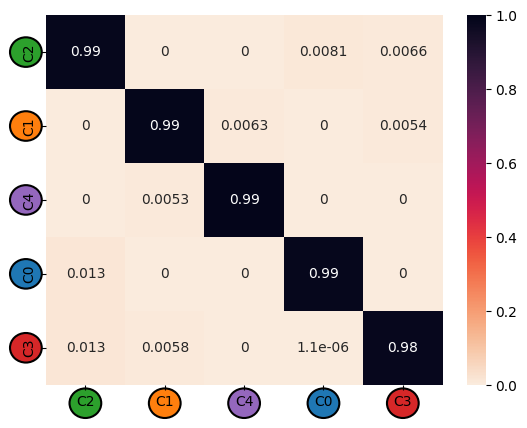

In [17]:
from SOAPify import SOAPclassification, calculateTransitionMatrix, normalizeMatrixByRow
from seaborn import heatmap

classifications = SOAPclassification(
    [], prepareData(classifiedFilteredtSOAP), [f"C{m[0]}" for m in minmax]
)
tmat = calculateTransitionMatrix(classifications)
tmat = normalizeMatrixByRow(tmat)
_, ax = plt.subplots(1)
heatmap(
    tmat,
    vmax=1,
    vmin=0,
    cmap="rocket_r",
    annot=True,
    xticklabels=classifications.legend,
    yticklabels=classifications.legend,
    ax=ax,
)

for i, label in enumerate(classifications.legend):
    ax.add_patch(
        Circle(
            (0.5 + i, len(classifications.legend) + 0.25),
            facecolor=label,
            lw=1.5,
            edgecolor="black",
            radius=0.2,
            clip_on=False,
        )
    )
    ax.add_patch(
        Circle(
            (-0.25, 0.5 + i),
            facecolor=label,
            lw=1.5,
            edgecolor="black",
            radius=0.2,
            clip_on=False,
        )
    )
